# This the final implementation of emotion recognition model for our project.

### There are other .ipynb files in this direcotry which have code for other model architectures we have implemented for comparision and experimenting.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
DATASET_DIR = r"FER-13" 

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 7

STEPS_PER_EPOCH = 1262  
EPOCHS_STAGE1 = 40
EPOCHS_STAGE2 = 60


In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, "train"),
    image_size=(48, 48),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, "test"),
    image_size=(48, 48),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
def preprocess_fer(x, y):
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    x = tf.image.grayscale_to_rgb(x)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    y = tf.one_hot(y, NUM_CLASSES)
    return x, y


In [17]:
def mixup(x, y, alpha=0.2):
    batch_size = tf.shape(x)[0]
    lam = tf.random.uniform([], 0, 1)

    index = tf.random.shuffle(tf.range(batch_size))
    mixed_x = lam * x + (1 - lam) * tf.gather(x, index)
    mixed_y = lam * y + (1 - lam) * tf.gather(y, index)

    return mixed_x, mixed_y


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(preprocess_fer, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(mixup, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.repeat()
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds = val_ds.map(preprocess_fer, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


## Training EffecientNetB3 model

In [19]:
base_model = tf.keras.applications.EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,580,214 (44.18 MB)

 Trainable params: 793,607 (3.03 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)


In [22]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="models/fedav_best_model-EfficientNetB3.weights.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=3,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]


In [23]:
os.makedirs("models", exist_ok=True)


In [26]:
import time

In [27]:
start_time = time.time()

history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("Stage 1 training time:", time.time() - start_time)


Epoch 1/40
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.3317 - loss: 2.1197
Epoch 1: val_accuracy improved from None to 0.49540, saving model to models/fedav_best_model-EfficientNetB3.weights.h5
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 854s 667ms/step - accuracy: 0.3728 - loss: 1.8625 - val_accuracy: 0.4954 - val_loss: 1.4740 - learning_rate: 0.0010
Epoch 2/40
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.4204 - loss: 1.6722
Epoch 2: val_accuracy improved from 0.49540 to 0.50084, saving model to models/fedav_best_model-EfficientNetB3.weights.h5
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 849s 673ms/step - accuracy: 0.4228 - loss: 1.6712 - val_accuracy: 0.5008 - val_loss: 1.4572 - learning_rate: 0.0010
Epoch 3/40
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.4305 - loss: 1.6693
Epoch 3: val_accuracy improved from 0.50084 to 0.51128, saving model to models/fedav_best_model-EfficientNetB3.weights.h5
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 840s 665ms/step - accuracy: 0.4304 - loss:

## Fine-Tuning the model

In [28]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    steps_per_epoch=1262,
    callbacks=callbacks
)


Epoch 1/60
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3881 - loss: 1.7074
Epoch 1: val_accuracy did not improve from 0.59083
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 3763s 3s/step - accuracy: 0.4437 - loss: 1.6477 - val_accuracy: 0.5829 - val_loss: 1.3236 - learning_rate: 1.0000e-04
Epoch 2/60
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5232 - loss: 1.5472
Epoch 2: val_accuracy improved from 0.59083 to 0.64182, saving model to models/fedav_best_model-EfficientNetB3.weights.h5
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 3461s 3s/step - accuracy: 0.5346 - loss: 1.5355 - val_accuracy: 0.6418 - val_loss: 1.2225 - learning_rate: 1.0000e-04
Epoch 3/60
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5675 - loss: 1.4941
Epoch 3: val_accuracy improved from 0.64182 to 0.64990, saving model to models/fedav_best_model-EfficientNetB3.weights.h5
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 3431s 3s/step - accuracy: 0.5768 - loss: 1.4820 - val_accuracy: 0.6499 - val_loss: 1.1840 - learning_rate: 1.0000e-

In [29]:
model.save("fer_efficientnet_b3_70pct.keras")

## Accuracy and loss graphs

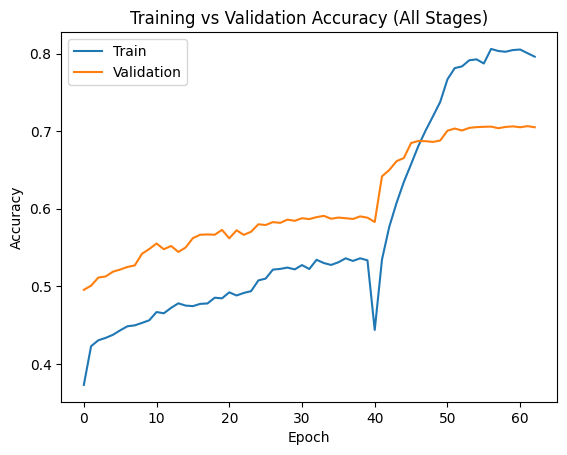

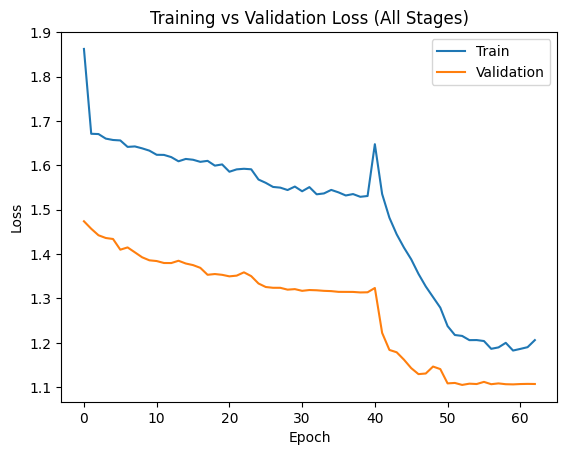

In [30]:
def combine_histories(h1, h2):
    combined = {}
    for k in h1.history.keys():
        combined[k] = h1.history[k] + h2.history[k]
    return combined

combined_history = combine_histories(history_1, history_2)

# Accuracy
plt.figure()
plt.plot(combined_history['accuracy'])
plt.plot(combined_history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (All Stages)')
plt.legend(['Train', 'Validation'])
plt.show()

# Loss
plt.figure()
plt.plot(combined_history['loss'])
plt.plot(combined_history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (All Stages)')
plt.legend(['Train', 'Validation'])
plt.show()


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# True labels
y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

# If labels are one-hot, convert to class indices
if len(y_true.shape) > 1:
    y_true = np.argmax(y_true, axis=1)

# Predictions
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


225/225 ━━━━━━━━━━━━━━━━━━━━ 102s 451ms/step
[[ 596    6   85   34   79  137   21]
 [  30   61    3    5    4    7    1]
 [  95    3  514   31  103  193   85]
 [  35    1   21 1577   81   25   34]
 [  52    0   49   77  850  187   18]
 [  99    2  137   51  197  747   14]
 [  21    0   57   35   19   13  686]]


## Confusion matrix of the model

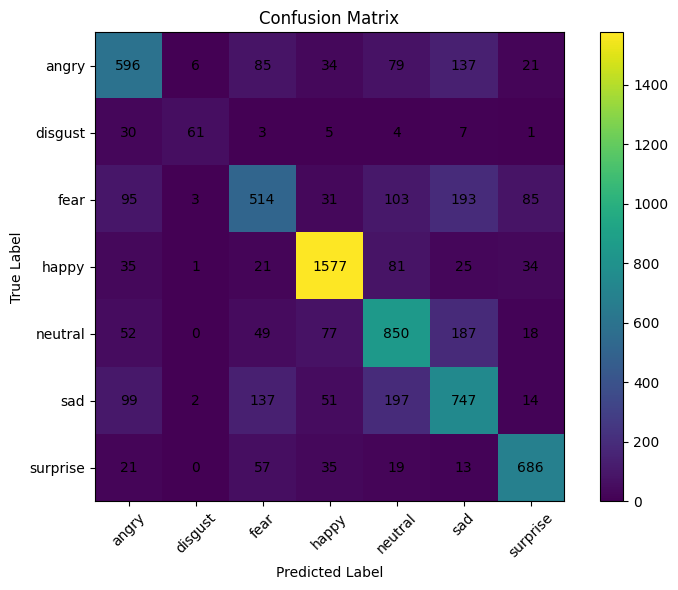

In [34]:
plt.figure(figsize=(8, 6))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


## Prediciton on random images

In [ ]:
def show_random_predictions(model, dataset, class_names, num_images=9):
    images = []
    labels = []

    for batch_images, batch_labels in dataset:
        images.append(batch_images)
        labels.append(batch_labels)

    images = tf.concat(images, axis=0)
    labels = tf.concat(labels, axis=0)

    if len(labels.shape) > 1:
        labels = tf.argmax(labels, axis=1)

    idxs = np.random.choice(len(images), num_images, replace=False)

    plt.figure(figsize=(12, 12))

    for i, idx in enumerate(idxs):
        img = images[idx]
        true_label = labels[idx].numpy()

        img_input = tf.expand_dims(img, axis=0)
        pred = model.predict(img_input, verbose=0)
        pred_label = np.argmax(pred)

        img_vis = tf.squeeze(img).numpy()

        if img_vis.max() <= 1.0:
            img_vis = img_vis * 255

        plt.subplot(3, 3, i + 1)
        plt.imshow(img_vis.astype("uint8"), cmap="gray")
        plt.axis("off")

        plt.title(
            f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
            color="green" if true_label == pred_label else "red"
        )

    plt.tight_layout()
    plt.show()


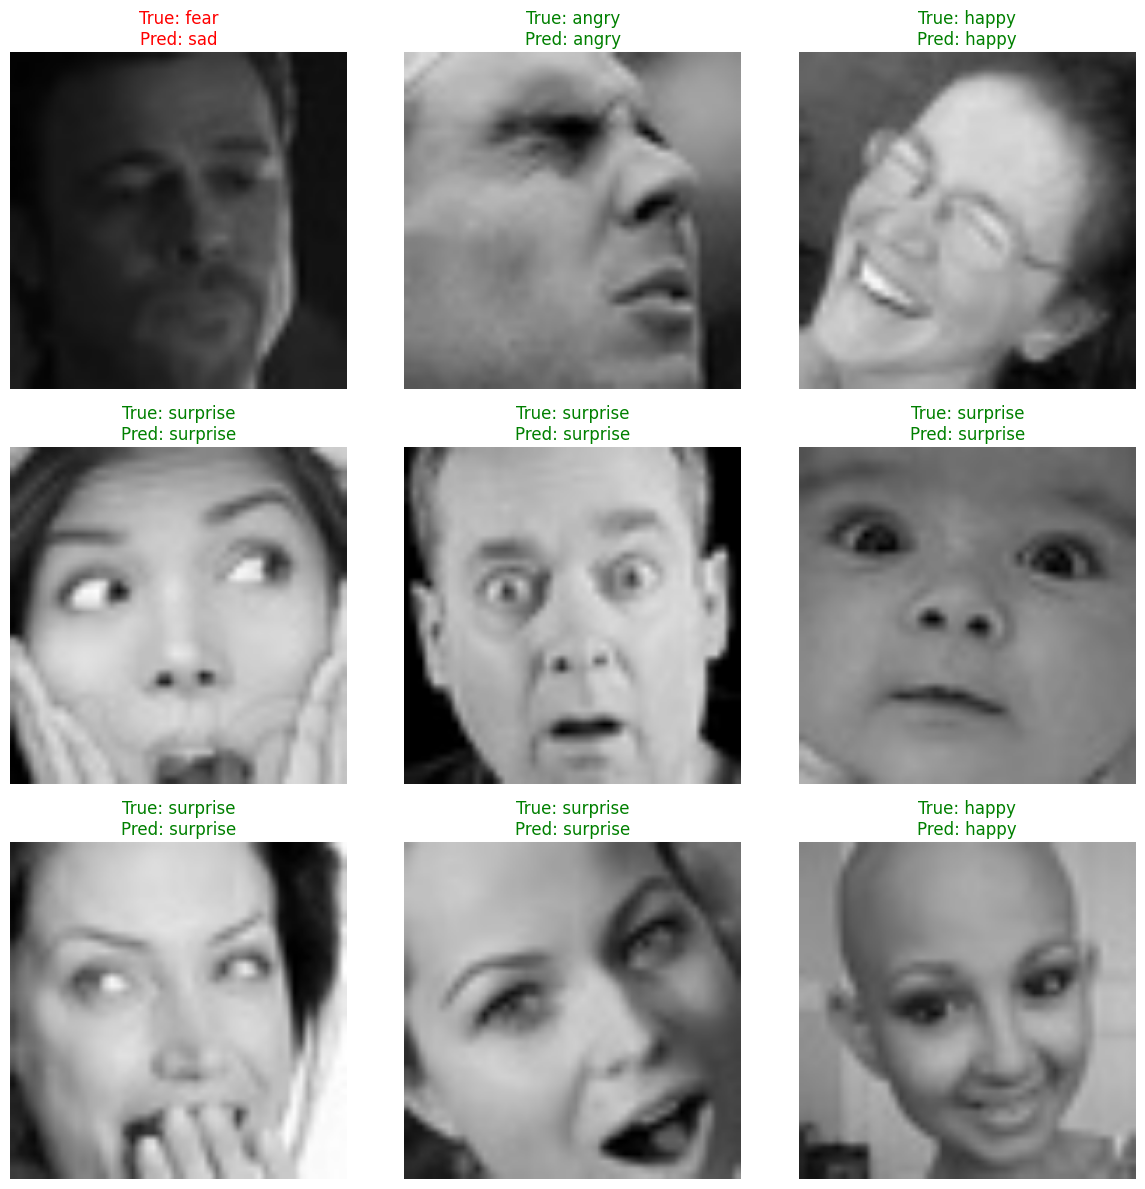

In [38]:
show_random_predictions(
    model=model,
    dataset=val_ds,
    class_names=class_names,
    num_images=9
)


## Prediction on one random image per class

In [39]:
def show_one_per_class(model, dataset, class_names):
    images = []
    labels = []

    for batch_images, batch_labels in dataset:
        images.append(batch_images)
        labels.append(batch_labels)

    images = tf.concat(images, axis=0)
    labels = tf.concat(labels, axis=0)

    if len(labels.shape) > 1:
        labels = tf.argmax(labels, axis=1)

    plt.figure(figsize=(14, 8))

    used = set()
    plot_idx = 1

    for i in range(len(images)):
        label = labels[i].numpy()

        if label in used:
            continue

        img = images[i]
        img_input = tf.expand_dims(img, axis=0)
        pred = model.predict(img_input, verbose=0)
        pred_label = np.argmax(pred)

        img_vis = tf.squeeze(img).numpy()
        if img_vis.max() <= 1.0:
            img_vis = img_vis * 255

        plt.subplot(2, 4, plot_idx)
        plt.imshow(img_vis.astype("uint8"), cmap="gray")
        plt.axis("off")

        plt.title(
            f"True: {class_names[label]}\nPred: {class_names[pred_label]}",
            color="green" if label == pred_label else "red"
        )

        used.add(label)
        plot_idx += 1

        if len(used) == len(class_names):
            break

    plt.tight_layout()
    plt.show()


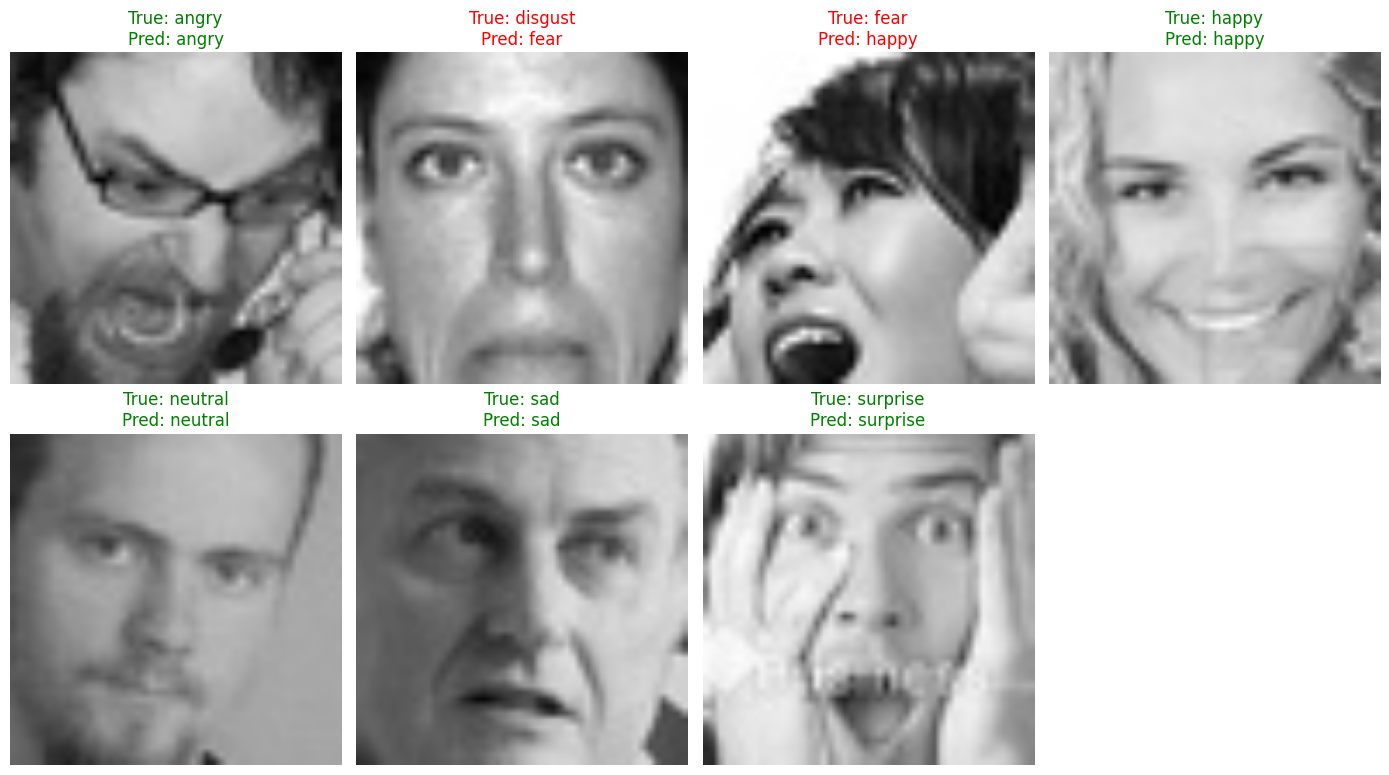

In [40]:
show_one_per_class(model, val_ds, class_names)
